In [2]:
import pandas as pd
import networkx as nx
from collections import Counter
from networkx.algorithms import bipartite
import community as community_louvain
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize
import seaborn as sns
import re
import numpy as np
import string
from datetime import datetime

### Load JSON data

In [2]:
with open('Truthseeker_retweet_network.json', 'r') as file:
    data = json.load(file)

### Basic Network Overview

In [145]:
G = nx.DiGraph()

for node in data['nodes']:
    G.add_node(node['id'], 
               friends_count=node.get('friends_count'), 
               followers_count=node.get('followers_count'), 
               BotScoreBinary=node.get('BotScoreBinary'), 
               timestamp=node.get('timestamp'))

for edge in data['edges']:
    G.add_edge(edge['source'], edge['target'], 
               interaction=edge.get('interaction'), 
               weight=edge.get('weight', 1))

In [146]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = (2 * num_edges) / num_nodes

print('Number of nodes:', num_nodes)
print('Number of edges:', num_edges)
print('Average degree:', avg_degree)

Number of nodes: 134351
Number of edges: 21273
Average degree: 0.31667795550461103


Number of fake tweets: 65268
Number of real tweets: 68930


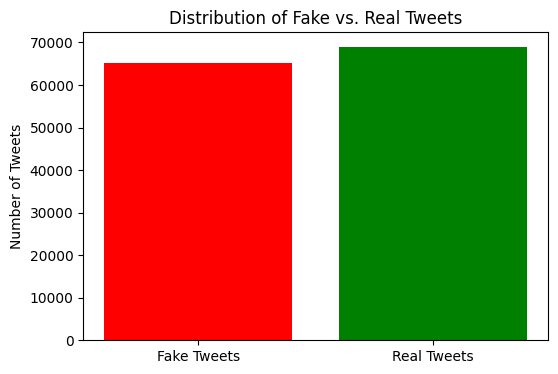

In [156]:
overview_df = pd.DataFrame(tweet_data)
fake_tweets = overview_df[overview_df['label'] == 0.0]
real_tweets = overview_df[overview_df['label'] == 1.0]
print('Number of fake tweets:', len(fake_tweets))
print('Number of real tweets:', len(real_tweets))

plt.figure(figsize=(6, 4))
plt.bar(['Fake Tweets', 'Real Tweets'], [len(fake_tweets), len(real_tweets)], color=['red', 'green'])
plt.title('Distribution of Fake vs. Real Tweets')
plt.ylabel('Number of Tweets')
plt.show()

## RQ1

### Community Detection

In [3]:
# Bipartite graph - tweets to authors

In [4]:
B = nx.Graph()  
tweet_nodes = set()
author_nodes = set()

for node in data['nodes']:
    tweet_id = node['id']
    B.add_node(tweet_id, bipartite='tweet', 
               label=node.get('label'), 
               friends_count=node.get('friends_count'), 
               followers_count=node.get('followers_count'), 
               BotScoreBinary=node.get('BotScoreBinary'), 
               timestamp=node.get('timestamp'))
    tweet_nodes.add(tweet_id)

for edge in data['edges']:
    tweet_id = edge['source']
    author = edge['target']
    B.add_node(author, bipartite='author')
    B.add_edge(tweet_id, author, weight=edge.get('weight', 1))
    author_nodes.add(author)

print(f"Bipartite graph: {B.number_of_nodes()} nodes ({len(tweet_nodes)} tweets, {len(author_nodes)} authors), {B.number_of_edges()} edges")

Bipartite graph: 134351 nodes (134199 tweets, 152 authors), 21273 edges


In [5]:
# Tweet-to-tweet graph to connect tweets that share the same author: weight = sum of retweet counts

In [6]:
G_tweet = bipartite.weighted_projected_graph(B, tweet_nodes)

print(f"Tweet-to-tweet projected graph: {G_tweet.number_of_nodes()} nodes, {G_tweet.number_of_edges()} edges")
print(f"Average degree: {2 * G_tweet.number_of_edges() / G_tweet.number_of_nodes():.5f}")

Tweet-to-tweet projected graph: 134199 nodes, 8812338 edges
Average degree: 131.33239


In [7]:
# Louvain community detection

In [8]:
if G_tweet.number_of_nodes() > 0 and G_tweet.number_of_edges() > 0:
    partition = community_louvain.best_partition(G_tweet, resolution=1.0)
    communities = set(partition.values())
    print(f"\nLouvain: Number of communities: {len(communities)}")
    
    community_sizes = {}
    for node, comm in partition.items():
        community_sizes[comm] = community_sizes.get(comm, 0) + 1
    print("Louvain: Community sizes (top 10):", sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5])


Louvain: Number of communities: 113078
Louvain: Community sizes (top 10): [(13, 2424), (42, 1660), (43, 1479), (236, 1276), (198, 1032)]


In [9]:
# Modularity analysis

In [10]:
communities_list = [set([n for n in G_tweet.nodes() if partition.get(n) == c]) for c in communities]
modularity_score = modularity(G_tweet, communities_list)
print(f"Louvain: Modularity: {modularity_score:.5f}")

Louvain: Modularity: 0.83318


In [11]:
# K-Clique analysis

In [12]:
if G_tweet.number_of_nodes() > 0:
    G_simple = nx.Graph(G_tweet)
    cliques = list(nx.find_cliques(G_simple))
    k3_cliques = [clique for clique in cliques if len(clique) >= 3] 
    print(f"\nK-Cliques: Number of 3-cliques or larger: {len(k3_cliques)}")


K-Cliques: Number of 3-cliques or larger: 134


In [13]:
# Analysis fake/real tweets in cliques

In [14]:
fake_in_cliques = 0
real_in_cliques = 0
fake_clique_count = 0
real_clique_count = 0

for clique in k3_cliques:
    for node in clique:
        if G_tweet.nodes[node]['label'] == 0.0:
            fake_in_cliques += 1
            fake_clique_count += 1
        elif G_tweet.nodes[node]['label'] == 1.0:
            real_in_cliques += 1
            real_clique_count += 1

total_clique_nodes = fake_in_cliques + real_in_cliques
if total_clique_nodes > 0:
    print(f"K-Cliques: Fake tweets in cliques: {fake_in_cliques} ({100 * fake_in_cliques / total_clique_nodes:.2f}%)")
    print(f"K-Cliques: Real tweets in cliques: {real_in_cliques} ({100 * real_in_cliques / total_clique_nodes:.2f}%)")
    print(f"K-Cliques: Cliques containing fake tweets: {fake_clique_count}")
    print(f"K-Cliques: Cliques containing real tweets: {real_clique_count}")

K-Cliques: Fake tweets in cliques: 9280 (43.69%)
K-Cliques: Real tweets in cliques: 11962 (56.31%)
K-Cliques: Cliques containing fake tweets: 9280
K-Cliques: Cliques containing real tweets: 11962


In [15]:
# Degree Centrality

In [16]:
degree_centrality = nx.degree_centrality(G_tweet)
    
fake_degrees = [degree_centrality[node] for node in G_tweet.nodes() if G_tweet.nodes[node]['label'] == 0.0]
real_degrees = [degree_centrality[node] for node in G_tweet.nodes() if G_tweet.nodes[node]['label'] == 1.0]
    
print("\nCentrality Analysis (Degree Centrality):")
print(f"Fake tweets: Mean degree centrality = {sum(fake_degrees) / len(fake_degrees) if fake_degrees else 0:.5f}")
print(f"Real tweets: Mean degree centrality = {sum(real_degrees) / len(real_degrees) if real_degrees else 0:.5f}")


Centrality Analysis (Degree Centrality):
Fake tweets: Mean degree centrality = 0.00121
Real tweets: Mean degree centrality = 0.00076


In [17]:
# Intra and inter edge analysis

In [158]:
fake_nodes = [node for node, attr in G_tweet.nodes(data=True) if attr.get('label') == 0.0]
intra_community_edges = 0
inter_community_edges = 0
fake_to_fake_edges = 0
fake_to_real_edges = 0
for source, target in G_tweet.edges():
    if G_tweet.nodes[source]['label'] == 0.0:
        if partition.get(source) == partition.get(target):
            intra_community_edges += 1
        else:
            inter_community_edges += 1
        if G_tweet.nodes[target]['label'] == 0.0:
            fake_to_fake_edges += 1
        else:
            fake_to_real_edges += 1
total_fake_edges = intra_community_edges + inter_community_edges
if total_fake_edges > 0:
    print(f"Louvain: Intra-community fake news edges: {intra_community_edges} ({100 * intra_community_edges / total_fake_edges:.2f}%)")
    print(f"Louvain: Inter-community fake news edges: {inter_community_edges} ({100 * inter_community_edges / total_fake_edges:.2f}%)")
    print(f"Louvain: Fake-to-fake edges: {fake_to_fake_edges} ({100 * fake_to_fake_edges / total_fake_edges:.2f}%)")
    print(f"Louvain: Fake-to-real edges: {fake_to_real_edges} ({100 * fake_to_real_edges / total_fake_edges:.2f}%)")

Louvain: Intra-community fake news edges: 5340046 (100.00%)
Louvain: Inter-community fake news edges: 0 (0.00%)
Louvain: Fake-to-fake edges: 4228052 (79.18%)
Louvain: Fake-to-real edges: 1111994 (20.82%)


### Visualizations for Community Structure

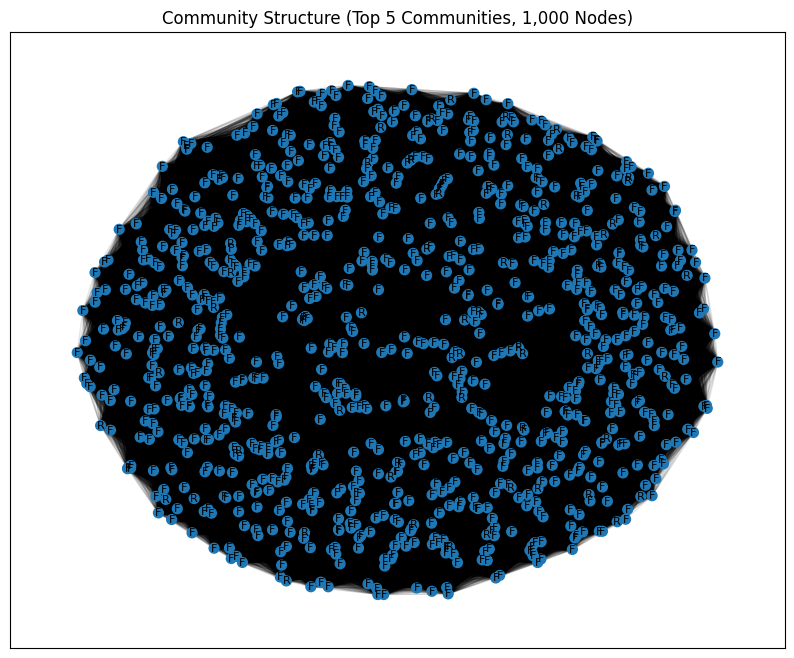

In [19]:
degree_dict = dict(G_tweet.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:1000]
G_subsample = G_tweet.subgraph(top_nodes)

community_sizes = Counter(partition.values())
top_communities = [comm for comm, size in community_sizes.most_common(5)]
node_colors = []
node_labels = {}
for node in G_subsample.nodes():
    comm = partition.get(node, -1)
    if comm in top_communities:
        node_colors.append(plt.cm.tab10(top_communities.index(comm) % 10))
    else:
        node_colors.append('gray')  # Other communities
    label = G_tweet.nodes[node]['label']
    node_labels[node] = 'F' if label == 0.0 else 'R'

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_subsample, k=0.1, iterations=20)
nx.draw_networkx_nodes(G_subsample, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_subsample, pos, alpha=0.1)
nx.draw_networkx_labels(G_subsample, pos, labels=node_labels, font_size=8, font_color='black')
plt.title("Community Structure (Top 5 Communities, 1,000 Nodes)")
plt.show()

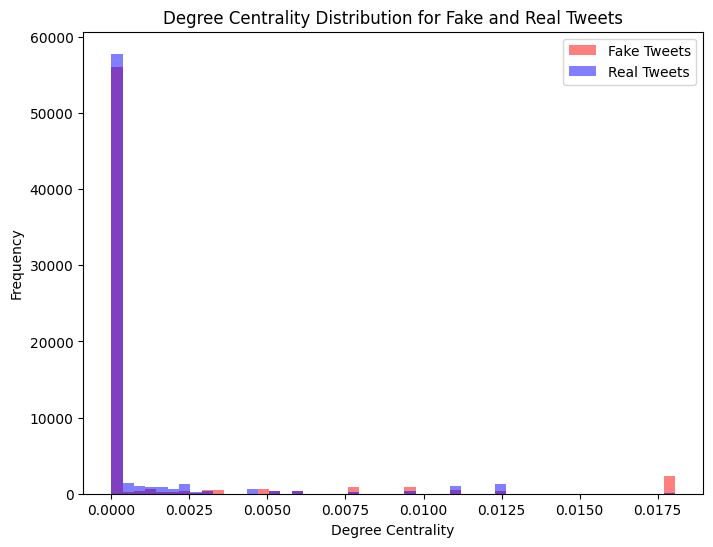

In [20]:
degree_centrality = nx.degree_centrality(G_tweet)
fake_degrees = [degree_centrality[node] for node in G_tweet.nodes() if G_tweet.nodes[node]['label'] == 0.0]
real_degrees = [degree_centrality[node] for node in G_tweet.nodes() if G_tweet.nodes[node]['label'] == 1.0]

plt.figure(figsize=(8, 6))
plt.hist(fake_degrees, bins=50, alpha=0.5, label='Fake Tweets', color='red')
plt.hist(real_degrees, bins=50, alpha=0.5, label='Real Tweets', color='blue')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Degree Centrality Distribution for Fake and Real Tweets')
plt.legend()
plt.show()

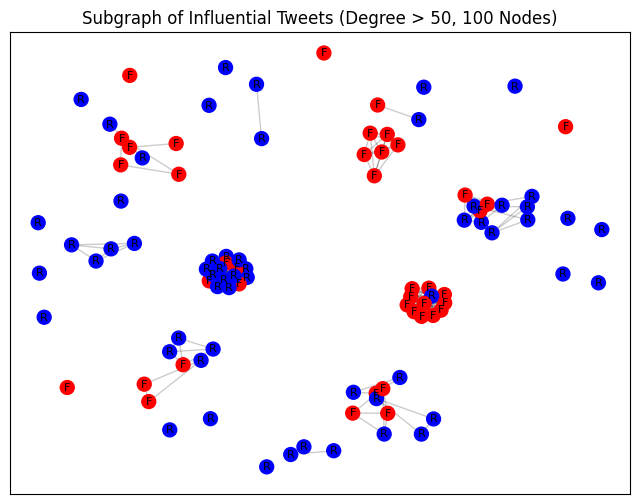

In [21]:
high_degree_nodes = [node for node, degree in G_tweet.degree() if degree > 50][:100]  
G_subgraph = G_tweet.subgraph(high_degree_nodes)

node_colors = ['red' if G_tweet.nodes[node]['label'] == 0.0 else 'blue' for node in G_subgraph.nodes()]
node_labels = {node: 'F' if G_tweet.nodes[node]['label'] == 0.0 else 'R' for node in G_subgraph.nodes()}

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_subgraph, k=0.15, iterations=20)
nx.draw_networkx_nodes(G_subgraph, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(G_subgraph, pos, alpha=0.2)
nx.draw_networkx_labels(G_subgraph, pos, labels=node_labels, font_size=8, font_color='black')
plt.title("Subgraph of Influential Tweets (Degree > 50, 100 Nodes)")
plt.show()

### RQ 2

In [23]:
# Graph filtering to contain tweets that have been retweeted >1

In [24]:
B_filtered = nx.Graph()
for u, v, attr in B.edges(data=True):
    if attr.get('weight', 0) >= 1 and attr.get('interaction', 'retweet') == 'retweet':
        B_filtered.add_edge(u, v, weight=attr.get('weight', 1))
        # Ensure node attributes are preserved
        if u in tweet_nodes and u in B.nodes:
            B_filtered.nodes[u].update(B.nodes[u])
        if v in author_nodes and v in B.nodes:
            B_filtered.nodes[v].update(B.nodes[v])

# Verify the filtered graph
print(
    f"B_filtered: {B_filtered.number_of_nodes()} nodes "
    f"({len([n for n in B_filtered.nodes if B_filtered.nodes[n].get('bipartite') == 'tweet'])} tweets, "
    f"{len([n for n in B_filtered.nodes if B_filtered.nodes[n].get('bipartite') == 'author'])} authors), "
    f"{B_filtered.number_of_edges()} edges"
)

B_filtered: 21425 nodes (21273 tweets, 152 authors), 21273 edges


In [25]:
# Proportion of fake tweets associated with each author's headlines

In [26]:
author_followers = {}
author_bot_score = {}
for author in author_nodes:
    followers = []
    bot_scores = []
    for tweet in B_filtered.neighbors(author):
        followers.append(float(B_filtered.nodes[tweet].get('followers_count', 0)))
        bot_scores.append(B_filtered.nodes[tweet].get('BotScoreBinary', 0))
    author_followers[author] = np.mean(followers) if followers else 0
    author_bot_score[author] = np.mean(bot_scores) if bot_scores else 0

author_fake_prop = {}
for author in author_nodes:
    tweets = list(B_filtered.neighbors(author))
    fake_count = sum(1 for t in tweets if B_filtered.nodes[t].get('label', 0) == 0.0)
    total_tweets = len(tweets)
    author_fake_prop[author] = fake_count / total_tweets if total_tweets > 0 else 0
    print(f"Author {author}: Fake proportion = {author_fake_prop[author]}")

Author: Kyra Haas, Avg Bot Score: 0.14, Fake Proportion: 0.00
Author: Haley BeMiller, Avg Bot Score: 0.10, Fake Proportion: 0.00
Author: Erin O'Neill, Avg Bot Score: 0.08, Fake Proportion: 0.00
Author: Austin Hough, Avg Bot Score: 0.08, Fake Proportion: 0.00
Author: Brett Chase, Avg Bot Score: 0.05, Fake Proportion: 0.00
Author: Mark Reynolds, Avg Bot Score: 0.04, Fake Proportion: 0.00
Author: Angie Drobnic, Avg Bot Score: 0.03, Fake Proportion: 0.03
Author: Dave Umhoefer, Avg Bot Score: 0.03, Fake Proportion: 0.00
Author: Gabrielle Settles, Avg Bot Score: 0.03, Fake Proportion: 1.00
Author: Michael Majchrowicz, Avg Bot Score: 0.03, Fake Proportion: 1.00
Author: Brandon Mulder, Avg Bot Score: 0.02, Fake Proportion: 0.90
Author: Mica Soellner, Avg Bot Score: 0.02, Fake Proportion: 0.00
Author: Patrick Orsagos, Avg Bot Score: 0.02, Fake Proportion: 0.67
Author: Madison Czopek, Avg Bot Score: 0.02, Fake Proportion: 1.00
Author: Sean Gorman, Avg Bot Score: 0.02, Fake Proportion: 0.00
Autho

In [28]:
clustering_coeff = nx.clustering(G_tweet)

Computing network structure metrics...
Clustering coefficient computed for 134199 nodes


In [29]:
fake_clustering = [clustering_coeff[t] for t in tweet_nodes if B.nodes[t].get('label') == 0.0]
real_clustering = [clustering_coeff[t] for t in tweet_nodes if B.nodes[t].get('label') == 1.0]
print(f"Fake clustering data points: {len(fake_clustering)}, Real clustering data points: {len(real_clustering)}")

Fake clustering data points: 65268, Real clustering data points: 68930


### Sentiment Analysis 

In [62]:
# Loading tweets into df

In [95]:
tweet_data = []
for node in data['nodes']:
    tweet_text = node.get('id', '')  
    label = node.get('label')  
    bot_score = node.get('BotScoreBinary', 0) 
    followers = node.get('followers_count', 0) 
    friends = node.get('friends_count', 0)      
    tweet_data.append({
        'tweet_id': tweet_text,  
        'original_text': tweet_text,
        'label': label,
        'BotScoreBinary': bot_score,
        'followers_count': followers,
        'friends_count': friends
    })
    
tweet_df = pd.DataFrame(tweet_data)

In [ ]:
# Cleaning and tokenization 

In [96]:
stops = set(stopwords.words('english'))
additional_stop_words = {"his", "that", "this"}
stops.update(additional_stop_words)


def clean_up_text(text):
    if not isinstance(text, str):
        return text
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    sentences = sent_tokenize(text)
    processed_sentences = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stops]
        processed_sentences.append(' '.join(filtered_words))
    return ' '.join(processed_sentences)

tweet_df['cleaned_text'] = tweet_df['original_text'].apply(clean_up_text)

print("\nSample Tweet Texts (first 2):")
print(tweet_df[['original_text', 'cleaned_text']].head(2))


Sample Tweet Texts (first 2):
                                       original_text  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl...   
1  @S0SickRick @Stairmaster_ @6d6f636869 Not as m...   

                                        cleaned_text  
0  biden blunders - 6 month update inflation , de...  
1  many people literally starving streets 19th ce...  


In [67]:
# Sentiment initialization

In [97]:
def get_sentiment_scores(text):
    scores = sid.polarity_scores(text)
    return scores

In [98]:
tweet_df['sentiment_scores'] = tweet_df['cleaned_text'].apply(get_sentiment_scores)
tweet_df['compound'] = tweet_df['sentiment_scores'].apply(lambda x: x['compound'])
tweet_df['pos'] = tweet_df['sentiment_scores'].apply(lambda x: x['pos'])
tweet_df['neg'] = tweet_df['sentiment_scores'].apply(lambda x: x['neg'])
tweet_df['neu'] = tweet_df['sentiment_scores'].apply(lambda x: x['neu'])

In [99]:
def label_sentiment(row):
    cutoff = 0.05 
    if row['compound'] < -1 * cutoff:
        return "neg"
    elif row['compound'] > cutoff:
        return "pos"
    else:
        return "neu"

tweet_df['sentiment_label'] = tweet_df.apply(label_sentiment, axis=1)
fake_df = tweet_df[tweet_df['label'] == 0.0].copy()
true_df = tweet_df[tweet_df['label'] == 1.0].copy()

In [100]:
print(f"Fake Tweets (Total: {len(fake_df)}):")
for sentiment in ['pos', 'neg', 'neu']:
    count = fake_sentiment_counts.get(sentiment, 0)
    percentage = (count / len(fake_df) * 100) if len(fake_df) > 0 else 0
    print(f"  {sentiment.capitalize()}: {count} ({percentage:.2f}%)")

print(f"True Tweets (Total: {len(true_df)}):")
for sentiment in ['pos', 'neg', 'neu']:
    count = true_sentiment_counts.get(sentiment, 0)
    percentage = (count / len(true_df) * 100) if len(true_df) > 0 else 0
    print(f"  {sentiment.capitalize()}: {count} ({percentage:.2f}%)")

Fake Tweets (Total: 65268):
  Pos: 22428 (34.36%)
  Neg: 35485 (54.37%)
  Neu: 7355 (11.27%)
True Tweets (Total: 68930):
  Pos: 26429 (38.34%)
  Neg: 32985 (47.85%)
  Neu: 9516 (13.81%)


In [ ]:
# Top Tweets 

In [101]:
def print_top_tweets(df, label, sentiment, ascending):
    print(f"\nTop {sentiment.capitalize()} {label.capitalize()} Top 5 Tweets:")
    filtered = df[df['sentiment_label'] == sentiment]
    if not filtered.empty:
        top = filtered.sort_values(by='compound', ascending=ascending).head(5)
        print(top[['cleaned_text', 'compound']])
    else:
        print(f"No {sentiment} {label.lower()} tweets found.")

for label, df in [('Fake', fake_df), ('True', true_df)]:
    for sentiment in ['pos', 'neg', 'neu']:
        ascending = True if sentiment == 'neg' else False
        print_top_tweets(df, label, sentiment, ascending)


Top Pos Fake Top 5 Tweets:
                                             cleaned_text  compound
131929  italy & gt ; puppet state & gt ; united kingdo...    0.9805
78739   awesome see daddy trump still living head rent...    0.9773
131700  like win win win new world order 1st win polic...    0.9756
84647   constitutionalist , great purveyor free speech...    0.9750
119444  say hello boy . special guy , '' president sai...    0.9747

Top Neg Fake Top 5 Tweets:
                                             cleaned_text  compound
56263   liars cheaters racist murderers perverts thiev...   -0.9934
97151   biden 's killer terror agenda -kill 70,000+ jo...   -0.9933
109316  fake ballot fraud backdated ballot fraud missi...   -0.9931
97280   bidens killer agenda -kill 70,000+ jobs -kill ...   -0.9922
97208   bidens killer agenda -kill 70,000+ jobs -kill ...   -0.9922

Top Neu Fake Top 5 Tweets:
                                            cleaned_text  compound
99523  coroner 's office admitted

In [102]:
def sentiment_percentages(fake_counts, true_counts, sentiment):
    fake_pct = (fake_counts.get(sentiment, 0) / len(fake_df) * 100) if len(fake_df) > 0 else 0
    true_pct = (true_counts.get(sentiment, 0) / len(true_df) * 100) if len(true_df) > 0 else 0
    print(f"{sentiment.capitalize()} Sentiment - Fake: {fake_pct:.2f}%, True: {true_pct:.2f}%")

print("\nSentiment Influence on Fake News Spread:")
for sentiment in ['neg', 'pos']:
    sentiment_percentages(fake_sentiment_counts, true_sentiment_counts, sentiment)


Sentiment Influence on Fake News Spread:
Neg Sentiment - Fake: 54.37%, True: 47.85%
Pos Sentiment - Fake: 34.36%, True: 38.34%


In [88]:
# Tweet and user metric comparison

In [108]:
tweet_df['followers_count'] = pd.to_numeric(tweet_df['followers_count'], errors='coerce')

fake_stats = tweet_df[tweet_df['label'] == 0][['followers_count', 'friends_count', 'BotScoreBinary']].describe().round(2)
true_stats = tweet_df[tweet_df['label'] == 1][['followers_count', 'friends_count', 'BotScoreBinary']].describe().round(2)

print("Fake Tweets Statistics:")
print(fake_stats)
print("\nTrue Tweets Statistics:")
print(true_stats)

Fake Tweets Statistics:
       followers_count  friends_count  BotScoreBinary
count         65267.00       65263.00        65263.00
mean           5127.27        1685.32            0.03
std          147739.52        6546.21            0.18
min               0.00           0.00            0.00
25%              51.00         139.00            0.00
50%             261.00         469.00            0.00
75%            1164.00        1455.00            0.00
max        34119943.00      538396.00            1.00

True Tweets Statistics:
       followers_count  friends_count  BotScoreBinary
count     6.893000e+04       68930.00        68930.00
mean      1.713046e+04        2090.38            0.03
std       5.932152e+05        7394.62            0.17
min       0.000000e+00           0.00            0.00
25%       9.800000e+01         205.00            0.00
50%       4.630000e+02         667.00            0.00
75%       2.052000e+03        1965.00            0.00
max       1.306019e+08      58690

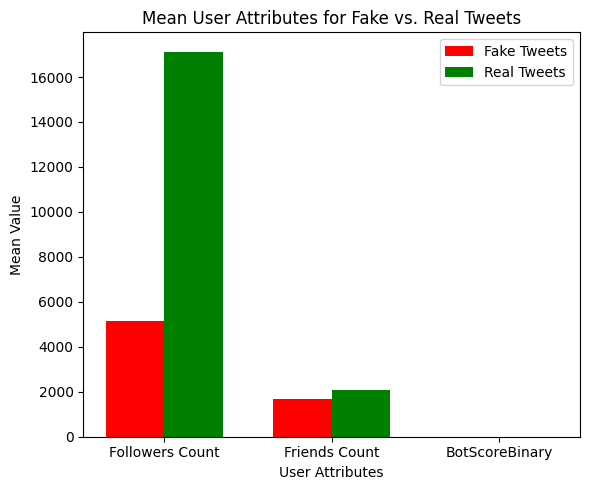

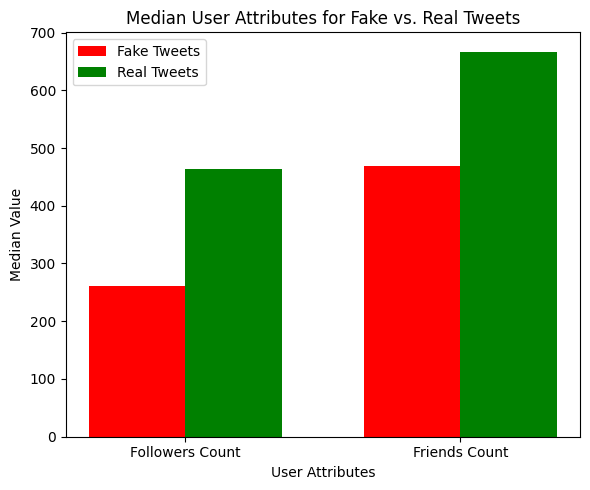

In [4]:
attributes = ['Followers Count', 'Friends Count', 'BotScoreBinary']
fake_means = [5127.27, 1685.32, 0.03]
real_means = [17130.46, 2090.38, 0.03]
fake_medians = [261, 469, None]  
real_medians = [463, 667, None] 

# Mean Values Comparison
plt.figure(figsize=(6, 5))
x = np.arange(len(attributes))
width = 0.35

plt.bar(x - width/2, fake_means, width, label='Fake Tweets', color='red')
plt.bar(x + width/2, real_means, width, label='Real Tweets', color='green')

plt.xlabel('User Attributes')
plt.ylabel('Mean Value')
plt.title('Mean User Attributes for Fake vs. Real Tweets')
plt.xticks(x, attributes)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
x = np.arange(2)  
width = 0.35

plt.bar(x - width/2, fake_medians[:2], width, label='Fake Tweets', color='red')
plt.bar(x + width/2, real_medians[:2], width, label='Real Tweets', color='green')

plt.xlabel('User Attributes')
plt.ylabel('Median Value')
plt.title('Median User Attributes for Fake vs. Real Tweets')
plt.xticks(x, ['Followers Count', 'Friends Count'])
plt.legend()
plt.tight_layout()
plt.show()

### Temporal analysis

In [ ]:
# New df for time

In [125]:
time_data = []
for node in data['nodes']:
    tweet_text = node.get('id', '')
    label = node.get('label', None)
    timestamp = node.get('timestamp', None)
    time_data.append({
        'tweet_id': tweet_text,
        'label': label,
        'timestamp': timestamp
    })
time_df = pd.DataFrame(time_data)

In [132]:
# Converting timestamp to date time and setting cut off date time

In [137]:
time_df['timestamp'] = pd.to_datetime(time_df['timestamp'], errors='coerce').dt.tz_localize(None)
dataset_publication_date = pd.to_datetime("2023-10-01")

In [134]:
time_df = time_df.dropna(subset=['timestamp'])

In [141]:
merged_df = time_df.drop(columns=[col for col in time_df.columns if col.startswith('spread_weight')], errors='ignore')
merged_df = merged_df.merge(spread_df, on='tweet_id', how='left')
merged_df['spread_weight'] = merged_df['spread_weight'].fillna(0)

In [143]:
merged_df['days_since_posting'] = (dataset_publication_date - merged_df['timestamp']).dt.days.clip(lower=1)
merged_df['retweets_per_day'] = merged_df['spread_weight'] / merged_df['days_since_posting']

summary = merged_df.groupby('label')['retweets_per_day'].describe()
print("Estimated Retweet Rate per Day:")
print(summary)

Estimated Retweet Rate per Day:
         count      mean       std  min  25%  50%  75%         max
label                                                             
0.0    65267.0  0.008325  0.557823  0.0  0.0  0.0  0.0  111.757092
1.0    68927.0  0.004383  0.122343  0.0  0.0  0.0  0.0   13.610939
